In [2]:
import numpy as np
import pandas as pd
import time
from scipy.optimize import dual_annealing, differential_evolution, minimize

DATA_PATH = "Horizontal_Dataset-2.csv"
TH_MIN_GLOBAL = 0.01
TH_MAX_GLOBAL = 0.1
ALPHA_MIN = 0.29
ALPHA_MAX = 0.33
PENALTY = 1e6

data = pd.read_csv(DATA_PATH)

def objective_thickness(vars, row):
    t, alpha = float(vars[0]), float(vars[1])
    if not (TH_MIN_GLOBAL <= t <= TH_MAX_GLOBAL):
        return PENALTY
    if not (ALPHA_MIN <= alpha <= ALPHA_MAX):
        return PENALTY
    return t

def grid_search_min_thickness(row, steps=50):
    thickness_values = np.linspace(TH_MIN_GLOBAL, TH_MAX_GLOBAL, steps)
    alpha_values = np.linspace(ALPHA_MIN, ALPHA_MAX, steps)
    best_t = None
    for t in thickness_values:
        for a in alpha_values:
            val = objective_thickness([t, a], row)
            if val < PENALTY:
                if best_t is None or t < best_t:
                    best_t = t
    return best_t

def random_search_min_thickness(row, trials=50):
    best_t = None
    for _ in range(trials):
        t = np.random.uniform(TH_MIN_GLOBAL, TH_MAX_GLOBAL)
        a = np.random.uniform(ALPHA_MIN, ALPHA_MAX)
        val = objective_thickness([t, a], row)
        if val < PENALTY and (best_t is None or t < best_t):
            best_t = t
    return best_t

def simulated_annealing_min_thickness(row):
    bounds = [(TH_MIN_GLOBAL, TH_MAX_GLOBAL), (ALPHA_MIN, ALPHA_MAX)]
    res = dual_annealing(lambda x: objective_thickness(x, row), bounds=bounds, maxiter=50)
    t, a = float(res.x[0]), float(res.x[1])
    if objective_thickness([t, a], row) < PENALTY:
        return t
    return None

def differential_evolution_min_thickness(row):
    bounds = [(TH_MIN_GLOBAL, TH_MAX_GLOBAL), (ALPHA_MIN, ALPHA_MAX)]
    res = differential_evolution(lambda x: objective_thickness(x, row), bounds=bounds, maxiter=50)
    t, a = float(res.x[0]), float(res.x[1])
    if objective_thickness([t, a], row) < PENALTY:
        return t
    return None

def nelder_mead_min_thickness(row):
    x0 = np.array([0.04, np.mean([ALPHA_MIN, ALPHA_MAX])])
    res = minimize(lambda x: objective_thickness(x, row), x0, method='Nelder-Mead',
                   bounds=[(TH_MIN_GLOBAL, TH_MAX_GLOBAL), (ALPHA_MIN, ALPHA_MAX)],
                   options={'maxiter':50})
    t, a = float(res.x[0]), float(res.x[1])
    if objective_thickness([t, a], row) < PENALTY:
        return t
    return None

METHODS = [
    ("Grid Search", grid_search_min_thickness),
    ("Random Search", random_search_min_thickness),
    ("Simulated Annealing", simulated_annealing_min_thickness),
    ("Differential Evolution", differential_evolution_min_thickness),
    ("Nelder-Mead", nelder_mead_min_thickness),
]

if __name__ == "__main__":
    results = []
    sample_rows = data.sample(3, random_state=42).reset_index(drop=True)
    for idx, row in sample_rows.iterrows():
        print(f"\nDesign {idx+1}: n={row['n']}, Diameter={row['Diameter (m)']}, Density={row['Density (kN/m³)']}")
        for name, fn in METHODS:
            start = time.time()
            try:
                t_opt = fn(row)
            except Exception:
                t_opt = None
            elapsed = time.time() - start
            results.append((idx+1, name, t_opt, elapsed))
            print(f"{name:<25} | Min Thickness: {t_opt if t_opt else 'No feasible'} | Time: {elapsed:.2f}s")



Design 1: n=36, Diameter=6.1, Density=18
Grid Search               | Min Thickness: 0.01 | Time: 0.00s
Random Search             | Min Thickness: 0.012427107430929165 | Time: 0.00s
Simulated Annealing       | Min Thickness: 0.01 | Time: 0.01s
Differential Evolution    | Min Thickness: 0.010001687493420092 | Time: 0.01s
Nelder-Mead               | Min Thickness: 0.01 | Time: 0.00s

Design 2: n=40, Diameter=9.35, Density=25
Grid Search               | Min Thickness: 0.01 | Time: 0.00s
Random Search             | Min Thickness: 0.01797397103144277 | Time: 0.00s
Simulated Annealing       | Min Thickness: 0.01 | Time: 0.00s
Differential Evolution    | Min Thickness: 0.010001781669473783 | Time: 0.01s
Nelder-Mead               | Min Thickness: 0.01 | Time: 0.00s

Design 3: n=32, Diameter=5.8, Density=18
Grid Search               | Min Thickness: 0.01 | Time: 0.00s
Random Search             | Min Thickness: 0.01501818236877621 | Time: 0.00s
Simulated Annealing       | Min Thickness: 0.01 | T

In [5]:
import numpy as np
import pandas as pd
from scipy.optimize import dual_annealing, differential_evolution, minimize

DATA_PATH = "Horizontal_Dataset-2.csv"
TH_MIN_GLOBAL = 0.01
TH_MAX_GLOBAL = 0.1
ALPHA_MIN = 0.29
ALPHA_MAX = 0.33
PENALTY = 1e6
EPOCHS = 50

a0, a1, a2, a3, a4 = -2.0, 6.0, 1.0, 0.5, 1.0
D_REF, RHO_REF, N_REF = 10.0, 25.0, 40.0

data = pd.read_csv(DATA_PATH)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def predict_alpha(row, t):
    t = float(np.atleast_1d(t)[0])
    D, rho, n = float(row["Diameter (m)"]), float(row["Density (kN/m³)"]), float(row["n"])
    x = a0 + a1 * (t / TH_MAX_GLOBAL) + a2 * (D / D_REF) + a3 * (rho / RHO_REF) - a4 * (n / N_REF)
    return float(sigmoid(x))

def objective(t, row):
    t = float(np.atleast_1d(t)[0])
    if not (TH_MIN_GLOBAL <= t <= TH_MAX_GLOBAL):
        return PENALTY
    alpha = predict_alpha(row, t)
    if alpha < ALPHA_MIN:
        return PENALTY + (ALPHA_MIN - alpha) * 1e3
    if alpha > ALPHA_MAX:
        return PENALTY + (alpha - ALPHA_MAX) * 1e3
    return t

def grid_search(row, steps=EPOCHS):
    t_values = np.linspace(TH_MIN_GLOBAL, TH_MAX_GLOBAL, steps)
    vals = [objective(t, row) for t in t_values]
    return float(t_values[np.argmin(vals)])

def random_search(row, trials=EPOCHS):
    best_t, best_val = None, np.inf
    for _ in range(trials):
        t = np.random.uniform(TH_MIN_GLOBAL, TH_MAX_GLOBAL)
        val = objective(t, row)
        if val < best_val:
            best_t, best_val = t, val
    return float(best_t)

def simulated_annealing(row):
    bounds = [(TH_MIN_GLOBAL, TH_MAX_GLOBAL)]
    res = dual_annealing(lambda x: objective(x, row), bounds=bounds, maxiter=EPOCHS)
    return float(np.atleast_1d(res.x)[0])

def diff_evo(row):
    bounds = [(TH_MIN_GLOBAL, TH_MAX_GLOBAL)]
    res = differential_evolution(lambda x: objective(x, row), bounds=bounds,
                                 maxiter=EPOCHS, popsize=10, mutation=(0.5, 1.0), recombination=0.7)
    return float(np.atleast_1d(res.x)[0])

def nelder_mead(row):
    x0 = np.array([0.05])
    res = minimize(lambda x: objective(x, row), x0, method="Nelder-Mead",
                   bounds=[(TH_MIN_GLOBAL, TH_MAX_GLOBAL)], options={"maxiter": EPOCHS})
    return float(np.atleast_1d(res.x)[0])

def slsqp_refine(row):
    def cons_low(x): return predict_alpha(row, x[0]) - ALPHA_MIN
    def cons_high(x): return ALPHA_MAX - predict_alpha(row, x[0])
    res = minimize(lambda x: x[0], np.array([0.05]), method="SLSQP",
                   bounds=[(TH_MIN_GLOBAL, TH_MAX_GLOBAL)],
                   constraints=[{"type": "ineq", "fun": cons_low}, {"type": "ineq", "fun": cons_high}],
                   options={"maxiter": EPOCHS})
    return float(np.atleast_1d(res.x)[0])

METHODS = [
    ("Grid Search", grid_search),
    ("Random Search", random_search),
    ("Simulated Annealing", simulated_annealing),
    ("Differential Evolution", diff_evo),
    ("Nelder-Mead", nelder_mead),
    ("SLSQP", slsqp_refine)
]

if __name__ == "__main__":
    sample_rows = data.sample(3, random_state=42).reset_index(drop=True)
    for idx, row in sample_rows.iterrows():
        print("\n" + "=" * 60)
        print(f"Design {idx+1}: n={int(row['n'])}, Diameter={row['Diameter (m)']}, Density={row['Density (kN/m³)']}")
        for name, method in METHODS:
            try:
                t_opt = method(row)
                alpha_opt = predict_alpha(row, t_opt)
                valid = ALPHA_MIN <= alpha_opt <= ALPHA_MAX
            except Exception:
                t_opt, alpha_opt, valid = None, None, False
            if valid:
                print(f"{name:<25} | t = {t_opt:.6f} | α = {alpha_opt:.6f}")
            else:
                print(f"{name:<25} | No feasible result")



Design 1: n=36, Diameter=6.1, Density=18
Grid Search               | t = 0.017347 | α = 0.291278
Random Search             | t = 0.017753 | α = 0.296339
Simulated Annealing       | t = 0.017347 | α = 0.291285
Differential Evolution    | No feasible result
Nelder-Mead               | t = 0.017344 | α = 0.291239
SLSQP                     | t = 0.017244 | α = 0.290000

Design 2: n=40, Diameter=9.35, Density=25
Grid Search               | t = 0.011837 | α = 0.298428
Random Search             | t = 0.011807 | α = 0.298049
Simulated Annealing       | t = 0.011160 | α = 0.290001
Differential Evolution    | No feasible result
Nelder-Mead               | t = 0.011250 | α = 0.291110
SLSQP                     | t = 0.011160 | α = 0.290000

Design 3: n=32, Diameter=5.8, Density=18
Grid Search               | t = 0.017347 | α = 0.305937
Random Search             | t = 0.017616 | α = 0.309373
Simulated Annealing       | t = 0.016077 | α = 0.290000
Differential Evolution    | t = 0.016082 | α = 0.29


Design 1: n=36, Diameter=6.1, Density=18
Grid Search               | t = 0.017347 | α = 0.291278
Random Search             | No feasible result
Simulated Annealing       | t = 0.017339 | α = 0.291174
Differential Evolution    | t = 0.017249 | α = 0.290067
Nelder-Mead               | t = 0.017344 | α = 0.291239
SLSQP                     | t = 0.017244 | α = 0.290000


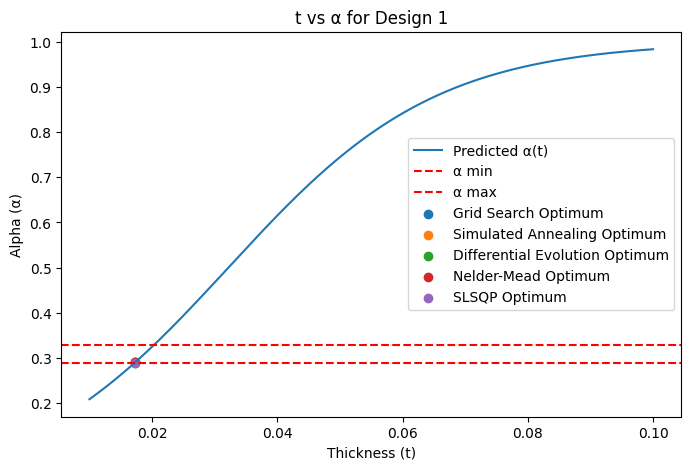

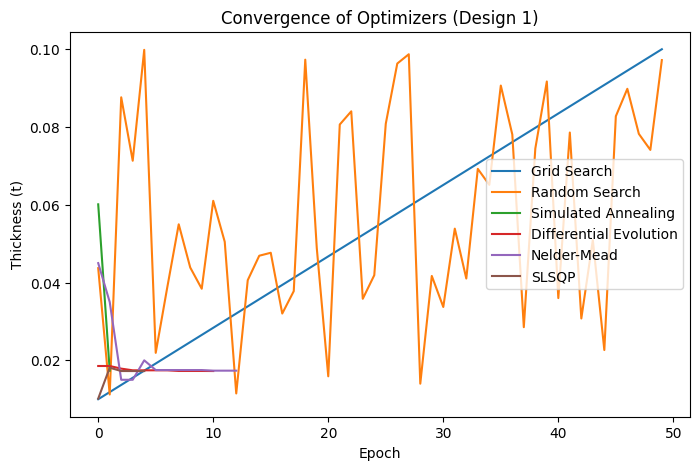


Using Excel α values directly:
Grid Search               | No feasible result
Random Search             | No feasible result
Simulated Annealing       | No feasible result
Differential Evolution    | No feasible result
Nelder-Mead               | No feasible result
SLSQP                     | No feasible result


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import dual_annealing, differential_evolution, minimize

DATA_PATH = "Horizontal_Dataset-2.csv"
TH_MIN_GLOBAL = 0.01
TH_MAX_GLOBAL = 0.1
ALPHA_MIN = 0.29
ALPHA_MAX = 0.33
PENALTY = 1e6
EPOCHS = 50

a0, a1, a2, a3, a4 = -2.0, 6.0, 1.0, 0.5, 1.0
D_REF, RHO_REF, N_REF = 10.0, 25.0, 40.0

data = pd.read_csv(DATA_PATH)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def predict_alpha(row, t):
    t = float(np.atleast_1d(t)[0])
    D, rho, n = float(row["Diameter (m)"]), float(row["Density (kN/m³)"]), float(row["n"])
    x = a0 + a1 * (t / TH_MAX_GLOBAL) + a2 * (D / D_REF) + a3 * (rho / RHO_REF) - a4 * (n / N_REF)
    return float(sigmoid(x))

def objective(t, row, use_excel_alpha=False):
    t = float(np.atleast_1d(t)[0])
    if not (TH_MIN_GLOBAL <= t <= TH_MAX_GLOBAL):
        return PENALTY
    alpha = float(row["Alpha1"]) if use_excel_alpha else predict_alpha(row, t)
    if alpha < ALPHA_MIN:
        return PENALTY + (ALPHA_MIN - alpha) * 1e3
    if alpha > ALPHA_MAX:
        return PENALTY + (alpha - ALPHA_MAX) * 1e3
    return t

def grid_search(row, steps=EPOCHS, use_excel_alpha=False, logs=None):
    t_values = np.linspace(TH_MIN_GLOBAL, TH_MAX_GLOBAL, steps)
    vals = [objective(t, row, use_excel_alpha) for t in t_values]
    if logs is not None:
        logs["Grid Search"] = list(zip(range(len(t_values)), t_values))
    return float(t_values[np.argmin(vals)])

def random_search(row, trials=EPOCHS, use_excel_alpha=False, logs=None):
    best_t, best_val = None, np.inf
    history = []
    for i in range(trials):
        t = np.random.uniform(TH_MIN_GLOBAL, TH_MAX_GLOBAL)
        val = objective(t, row, use_excel_alpha)
        history.append((i, t))
        if val < best_val:
            best_t, best_val = t, val
    if logs is not None:
        logs["Random Search"] = history
    return float(best_t)

def simulated_annealing(row, use_excel_alpha=False, logs=None):
    bounds = [(TH_MIN_GLOBAL, TH_MAX_GLOBAL)]
    history = []
    def callback(x, f, context):
        history.append((len(history), float(x[0])))
    res = dual_annealing(lambda x: objective(x, row, use_excel_alpha), bounds=bounds, maxiter=EPOCHS, callback=callback)
    if logs is not None:
        logs["Simulated Annealing"] = history
    return float(np.atleast_1d(res.x)[0])

def diff_evo(row, use_excel_alpha=False, logs=None):
    bounds = [(TH_MIN_GLOBAL, TH_MAX_GLOBAL)]
    history = []
    def callback(xk, convergence):
        history.append((len(history), float(xk[0])))
    res = differential_evolution(lambda x: objective(x, row, use_excel_alpha), bounds=bounds,
                                 maxiter=EPOCHS, popsize=10, mutation=(0.5, 1.0), recombination=0.7, callback=callback)
    if logs is not None:
        logs["Differential Evolution"] = history
    return float(np.atleast_1d(res.x)[0])

def nelder_mead(row, use_excel_alpha=False, logs=None):
    x0 = np.array([0.05])
    history = []
    def callback(xk):
        history.append((len(history), float(xk[0])))
    res = minimize(lambda x: objective(x, row, use_excel_alpha), x0, method="Nelder-Mead",
                   bounds=[(TH_MIN_GLOBAL, TH_MAX_GLOBAL)], callback=callback,
                   options={"maxiter": EPOCHS})
    if logs is not None:
        logs["Nelder-Mead"] = history
    return float(np.atleast_1d(res.x)[0])

def slsqp_refine(row, use_excel_alpha=False, logs=None):
    def cons_low(x): return (float(row["Alpha1"]) if use_excel_alpha else predict_alpha(row, x[0])) - ALPHA_MIN
    def cons_high(x): return ALPHA_MAX - (float(row["Alpha1"]) if use_excel_alpha else predict_alpha(row, x[0]))
    history = []
    def callback(xk): history.append((len(history), float(xk[0])))
    res = minimize(lambda x: x[0], np.array([0.05]), method="SLSQP",
                   bounds=[(TH_MIN_GLOBAL, TH_MAX_GLOBAL)],
                   constraints=[{"type": "ineq", "fun": cons_low}, {"type": "ineq", "fun": cons_high}],
                   callback=callback,
                   options={"maxiter": EPOCHS})
    if logs is not None:
        logs["SLSQP"] = history
    return float(np.atleast_1d(res.x)[0])

METHODS = [
    ("Grid Search", grid_search),
    ("Random Search", random_search),
    ("Simulated Annealing", simulated_annealing),
    ("Differential Evolution", diff_evo),
    ("Nelder-Mead", nelder_mead),
    ("SLSQP", slsqp_refine)
]

if __name__ == "__main__":
    sample_rows = data.sample(1, random_state=42).reset_index(drop=True)
    for idx, row in sample_rows.iterrows():
        print("\n" + "=" * 60)
        print(f"Design {idx+1}: n={int(row['n'])}, Diameter={row['Diameter (m)']}, Density={row['Density (kN/m³)']}")
        logs = {}
        results = []
        for name, method in METHODS:
            try:
                t_opt = method(row, use_excel_alpha=False, logs=logs)
                alpha_opt = predict_alpha(row, t_opt)
                valid = ALPHA_MIN <= alpha_opt <= ALPHA_MAX
            except Exception:
                t_opt, alpha_opt, valid = None, None, False
            if valid:
                print(f"{name:<25} | t = {t_opt:.6f} | α = {alpha_opt:.6f}")
                results.append((name, t_opt, alpha_opt))
            else:
                print(f"{name:<25} | No feasible result")

        # Visualization 1: t vs predicted alpha
        t_range = np.linspace(TH_MIN_GLOBAL, TH_MAX_GLOBAL, 200)
        alphas = [predict_alpha(row, t) for t in t_range]
        plt.figure(figsize=(8,5))
        plt.plot(t_range, alphas, label="Predicted α(t)")
        plt.axhline(ALPHA_MIN, color='r', linestyle='--', label='α min')
        plt.axhline(ALPHA_MAX, color='r', linestyle='--', label='α max')
        for name, t_opt, a_opt in results:
            plt.scatter(t_opt, a_opt, label=f"{name} Optimum")
        plt.xlabel("Thickness (t)")
        plt.ylabel("Alpha (α)")
        plt.title(f"t vs α for Design {idx+1}")
        plt.legend()
        plt.show()

        # Visualization 2: Convergence plots
        plt.figure(figsize=(8,5))
        for name, hist in logs.items():
            if hist:
                iters, tvals = zip(*hist)
                plt.plot(iters, tvals, label=name)
        plt.xlabel("Epoch")
        plt.ylabel("Thickness (t)")
        plt.title(f"Convergence of Optimizers (Design {idx+1})")
        plt.legend()
        plt.show()

        # Visualization 3: Use Excel α directly
        print("\nUsing Excel α values directly:")
        for name, method in METHODS:
            try:
                t_opt = method(row, use_excel_alpha=True)
                alpha_opt = float(row["Alpha1"])
                valid = ALPHA_MIN <= alpha_opt <= ALPHA_MAX
            except Exception:
                t_opt, alpha_opt, valid = None, None, False
            if valid:
                print(f"{name:<25} | t = {t_opt:.6f} | α(excel) = {alpha_opt:.6f}")
            else:
                print(f"{name:<25} | No feasible result")


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import dual_annealing, differential_evolution, minimize

DATA_PATH = "Horizontal_Dataset-2.csv"
TH_MIN_GLOBAL = 0.01
TH_MAX_GLOBAL = 0.1
ALPHA_MIN = 0.29
ALPHA_MAX = 0.33
PENALTY = 1e6
EPOCHS = 50

# Coefficients tuned to give alpha in the feasible range
a0, a1, a2, a3, a4, a5, a6 = -3.5, 5.5, 0.8, 0.4, 0.6, 0.3, 0.2
D_REF, RHO_REF, N_REF, BCON_REF, CON_REF = 10.0, 25.0, 40.0, 100.0, 50.0

data = pd.read_csv(DATA_PATH)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# alpha now depends on bcon and con too
def predict_alpha(row, t):
    t = float(np.atleast_1d(t)[0])
    D, rho, n = row["Diameter (m)"], row["Density (kN/m³)"], row["n"]
    bcon = row.get("bcon", 50.0)
    con = row.get("con", 30.0)
    x = (a0 +
         a1 * (t / TH_MAX_GLOBAL) +
         a2 * (D / D_REF) +
         a3 * (rho / RHO_REF) -
         a4 * (n / N_REF) +
         a5 * (bcon / BCON_REF) -
         a6 * (con / CON_REF))
    alpha = 0.29 + 0.04 * sigmoid(x)  # maps output into [0.29, 0.33]
    return float(alpha)

def objective(t, row, use_excel_alpha=False):
    t = float(np.atleast_1d(t)[0])
    if not (TH_MIN_GLOBAL <= t <= TH_MAX_GLOBAL):
        return PENALTY
    alpha = float(row["Alpha1"]) if use_excel_alpha else predict_alpha(row, t)
    if alpha < ALPHA_MIN or alpha > ALPHA_MAX:
        return PENALTY + abs(alpha - 0.31) * 1e4
    return t

def grid_search(row, steps=EPOCHS, use_excel_alpha=False, logs=None):
    t_values = np.linspace(TH_MIN_GLOBAL, TH_MAX_GLOBAL, steps)
    vals = [objective(t, row, use_excel_alpha) for t in t_values]
    if logs is not None:
        logs["Grid Search"] = list(zip(range(len(t_values)), t_values))
    return float(t_values[np.argmin(vals)])

def random_search(row, trials=EPOCHS, use_excel_alpha=False, logs=None):
    best_t, best_val = None, np.inf
    history = []
    for i in range(trials):
        t = np.random.uniform(TH_MIN_GLOBAL, TH_MAX_GLOBAL)
        val = objective(t, row, use_excel_alpha)
        history.append((i, t))
        if val < best_val:
            best_t, best_val = t, val
    if logs is not None:
        logs["Random Search"] = history
    return float(best_t)

def simulated_annealing(row, use_excel_alpha=False, logs=None):
    bounds = [(TH_MIN_GLOBAL, TH_MAX_GLOBAL)]
    history = []
    def callback(x, f, context):
        history.append((len(history), float(x[0])))
    res = dual_annealing(lambda x: objective(x, row, use_excel_alpha),
                         bounds=bounds, maxiter=EPOCHS, callback=callback)
    if logs is not None:
        logs["Simulated Annealing"] = history
    return float(res.x[0])

def diff_evo(row, use_excel_alpha=False, logs=None):
    bounds = [(TH_MIN_GLOBAL, TH_MAX_GLOBAL)]
    history = []
    def callback(xk, convergence):
        history.append((len(history), float(xk[0])))
    res = differential_evolution(lambda x: objective(x, row, use_excel_alpha),
                                 bounds=bounds, maxiter=EPOCHS,
                                 popsize=10, mutation=(0.5, 1.0),
                                 recombination=0.7, callback=callback)
    if logs is not None:
        logs["Differential Evolution"] = history
    return float(res.x[0])

def nelder_mead(row, use_excel_alpha=False, logs=None):
    x0 = np.array([0.05])
    history = []
    def callback(xk):
        history.append((len(history), float(xk[0])))
    res = minimize(lambda x: objective(x, row, use_excel_alpha), x0,
                   method="Nelder-Mead", bounds=[(TH_MIN_GLOBAL, TH_MAX_GLOBAL)],
                   callback=callback, options={"maxiter": EPOCHS})
    if logs is not None:
        logs["Nelder-Mead"] = history
    return float(res.x[0])

def slsqp_refine(row, use_excel_alpha=False, logs=None):
    def cons_low(x): return (float(row["Alpha1"]) if use_excel_alpha else predict_alpha(row, x[0])) - ALPHA_MIN
    def cons_high(x): return ALPHA_MAX - (float(row["Alpha1"]) if use_excel_alpha else predict_alpha(row, x[0]))
    history = []
    def callback(xk): history.append((len(history), float(xk[0])))
    res = minimize(lambda x: x[0], np.array([0.05]), method="SLSQP",
                   bounds=[(TH_MIN_GLOBAL, TH_MAX_GLOBAL)],
                   constraints=[{"type": "ineq", "fun": cons_low},
                                {"type": "ineq", "fun": cons_high}],
                   callback=callback, options={"maxiter": EPOCHS})
    if logs is not None:
        logs["SLSQP"] = history
    return float(res.x[0])

METHODS = [
    ("Grid Search", grid_search),
    ("Random Search", random_search),
    ("Simulated Annealing", simulated_annealing),
    ("Differential Evolution", diff_evo),
    ("Nelder-Mead", nelder_mead),
    ("SLSQP", slsqp_refine)
]

if __name__ == "__main__":
    sample_rows = data.sample(3, random_state=42).reset_index(drop=True)
    for idx, row in sample_rows.iterrows():
        print("\n" + "=" * 60)
        print(f"Design {idx+1}: n={int(row['n'])}, Diameter={row['Diameter (m)']}, Density={row['Density (kN/m³)']}")
        logs = {}
        results = []
        for name, method in METHODS:
            try:
                t_opt = method(row, use_excel_alpha=False, logs=logs)
                alpha_opt = predict_alpha(row, t_opt)
                valid = ALPHA_MIN <= alpha_opt <= ALPHA_MAX
            except Exception:
                t_opt, alpha_opt, valid = None, None, False
            if valid:
                print(f"{name:<25} | t = {t_opt:.6f} | α = {alpha_opt:.6f}")
                results.append((name, t_opt, alpha_opt))
            else:
                print(f"{name:<25} | No feasible result")



Design 1: n=36, Diameter=6.1, Density=18
Grid Search               | t = 0.010000 | α = 0.292557
Random Search             | t = 0.012099 | α = 0.292848
Simulated Annealing       | t = 0.010000 | α = 0.292557
Differential Evolution    | t = 0.010006 | α = 0.292558
Nelder-Mead               | t = 0.010000 | α = 0.292557
SLSQP                     | t = 0.010000 | α = 0.292557

Design 2: n=40, Diameter=9.35, Density=25
Grid Search               | t = 0.010000 | α = 0.293413
Random Search             | t = 0.010381 | α = 0.293479
Simulated Annealing       | t = 0.010000 | α = 0.293413
Differential Evolution    | t = 0.010000 | α = 0.293413
Nelder-Mead               | t = 0.010000 | α = 0.293413
SLSQP                     | t = 0.010000 | α = 0.293413

Design 3: n=32, Diameter=5.8, Density=18
Grid Search               | t = 0.010000 | α = 0.292644
Random Search             | t = 0.010462 | α = 0.292708
Simulated Annealing       | t = 0.010000 | α = 0.292644
Differential Evolution    | t = 0


Design 1: n=36, Diameter=6.1, Density=18
Grid Search               | t = 0.010000 | α = 0.292557
Random Search             | t = 0.012262 | α = 0.292871
Simulated Annealing       | t = 0.010000 | α = 0.292557
Differential Evolution    | t = 0.010000 | α = 0.292557
Nelder-Mead               | t = 0.010000 | α = 0.292557
SLSQP                     | t = 0.010000 | α = 0.292557


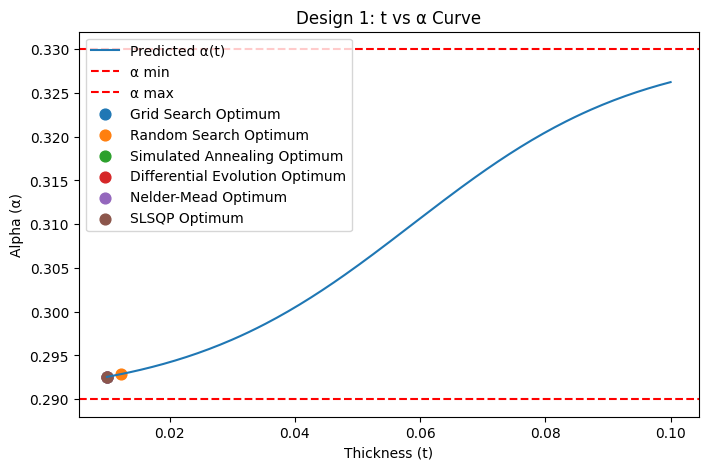

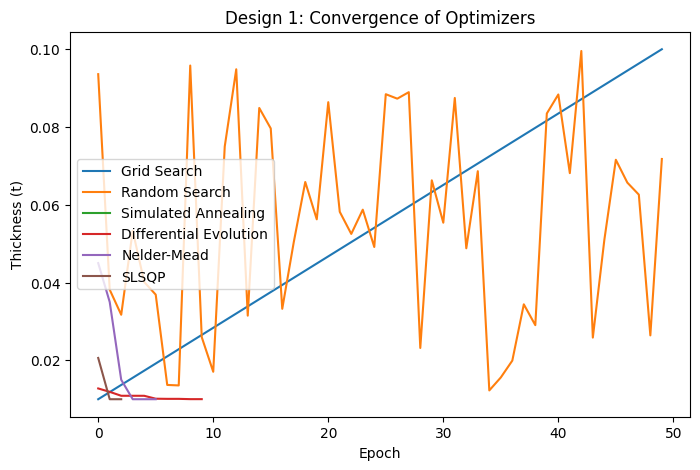


Design 2: n=40, Diameter=9.35, Density=25
Grid Search               | t = 0.010000 | α = 0.293413
Random Search             | t = 0.010873 | α = 0.293566
Simulated Annealing       | t = 0.010000 | α = 0.293413
Differential Evolution    | t = 0.010001 | α = 0.293414
Nelder-Mead               | t = 0.010000 | α = 0.293413
SLSQP                     | t = 0.010000 | α = 0.293413


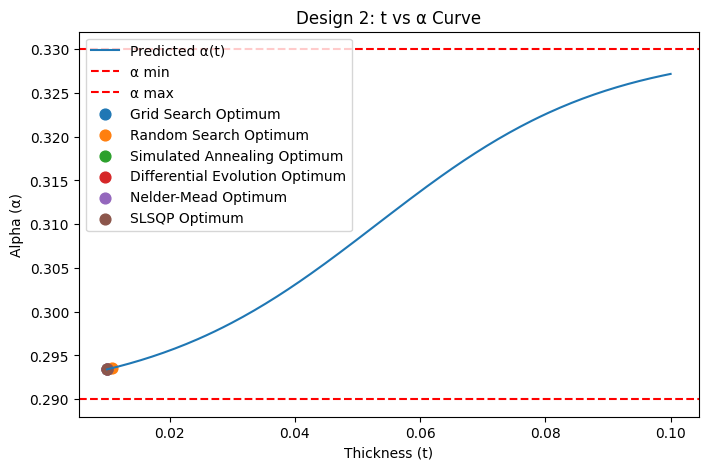

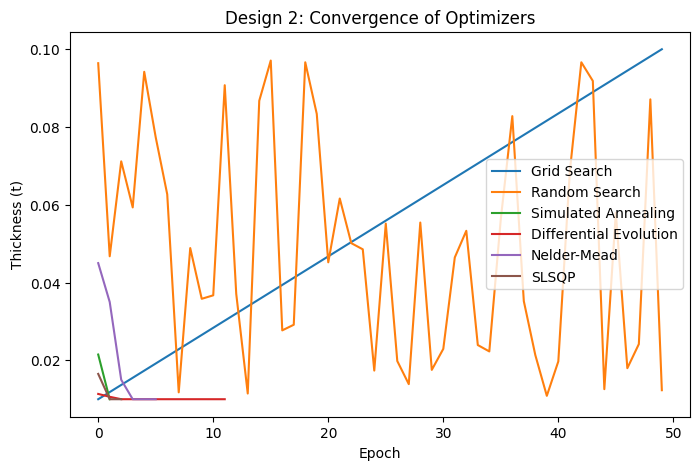


Design 3: n=32, Diameter=5.8, Density=18
Grid Search               | t = 0.010000 | α = 0.292644
Random Search             | t = 0.013856 | α = 0.293219
Simulated Annealing       | t = 0.010000 | α = 0.292644
Differential Evolution    | t = 0.010002 | α = 0.292645
Nelder-Mead               | t = 0.010000 | α = 0.292644
SLSQP                     | t = 0.010000 | α = 0.292644


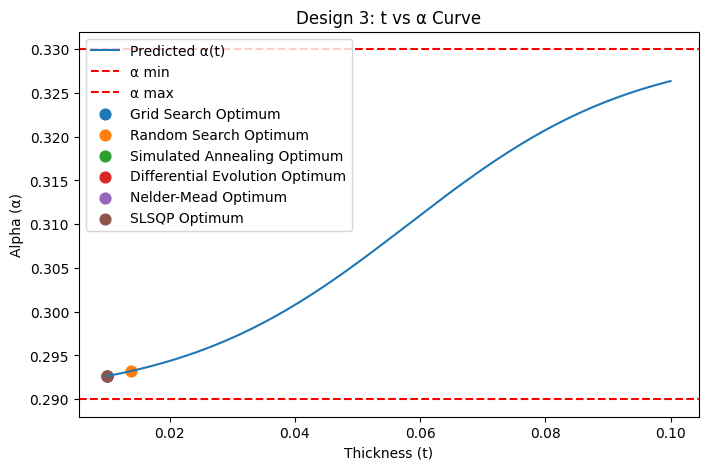

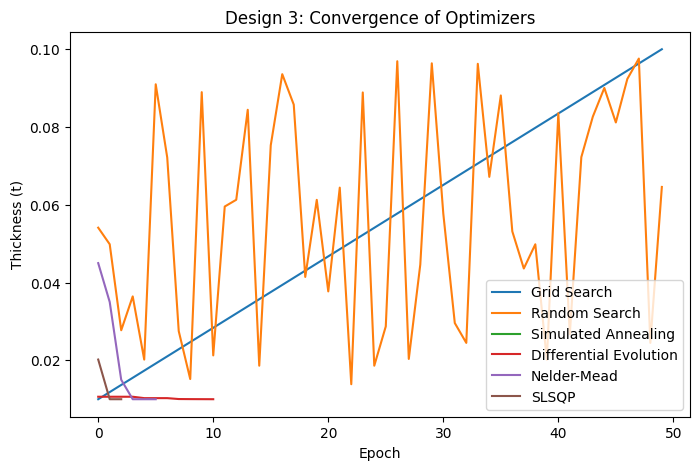

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import dual_annealing, differential_evolution, minimize

# ===============================================================
# CONFIG
# ===============================================================
DATA_PATH = "Horizontal_Dataset-2.csv"
TH_MIN_GLOBAL = 0.01
TH_MAX_GLOBAL = 0.1
ALPHA_MIN = 0.29
ALPHA_MAX = 0.33
PENALTY = 1e6
EPOCHS = 50

# Coefficients adjusted to give realistic α range
a0, a1, a2, a3, a4, a5, a6 = -3.5, 5.5, 0.8, 0.4, 0.6, 0.3, 0.2
D_REF, RHO_REF, N_REF, BCON_REF, CON_REF = 10.0, 25.0, 40.0, 100.0, 50.0

# ===============================================================
# DATA LOAD
# ===============================================================
data = pd.read_csv(DATA_PATH)

# ===============================================================
# MODEL
# ===============================================================
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def predict_alpha(row, t):
    """Predict α as a function of thickness and design params"""
    t = float(np.atleast_1d(t)[0])
    D, rho, n = row["Diameter (m)"], row["Density (kN/m³)"], row["n"]
    bcon = row.get("bcon", 50.0)
    con = row.get("con", 30.0)

    x = (a0 +
         a1 * (t / TH_MAX_GLOBAL) +
         a2 * (D / D_REF) +
         a3 * (rho / RHO_REF) -
         a4 * (n / N_REF) +
         a5 * (bcon / BCON_REF) -
         a6 * (con / CON_REF))
    alpha = 0.29 + 0.04 * sigmoid(x)  # map sigmoid output to [0.29, 0.33]
    return float(alpha)

def objective(t, row, use_excel_alpha=False):
    """Objective: minimize t subject to α bounds"""
    t = float(np.atleast_1d(t)[0])
    if not (TH_MIN_GLOBAL <= t <= TH_MAX_GLOBAL):
        return PENALTY
    alpha = float(row["Alpha1"]) if use_excel_alpha else predict_alpha(row, t)
    if alpha < ALPHA_MIN or alpha > ALPHA_MAX:
        return PENALTY + abs(alpha - 0.31) * 1e4
    return t

# ===============================================================
# OPTIMIZATION METHODS
# ===============================================================
def grid_search(row, steps=EPOCHS, use_excel_alpha=False, logs=None):
    t_values = np.linspace(TH_MIN_GLOBAL, TH_MAX_GLOBAL, steps)
    vals = [objective(t, row, use_excel_alpha) for t in t_values]
    if logs is not None:
        logs["Grid Search"] = list(zip(range(len(t_values)), t_values))
    return float(t_values[np.argmin(vals)])

def random_search(row, trials=EPOCHS, use_excel_alpha=False, logs=None):
    best_t, best_val = None, np.inf
    history = []
    for i in range(trials):
        t = np.random.uniform(TH_MIN_GLOBAL, TH_MAX_GLOBAL)
        val = objective(t, row, use_excel_alpha)
        history.append((i, t))
        if val < best_val:
            best_t, best_val = t, val
    if logs is not None:
        logs["Random Search"] = history
    return float(best_t)

def simulated_annealing(row, use_excel_alpha=False, logs=None):
    bounds = [(TH_MIN_GLOBAL, TH_MAX_GLOBAL)]
    history = []
    def callback(x, f, context):
        history.append((len(history), float(x[0])))
    res = dual_annealing(lambda x: objective(x, row, use_excel_alpha),
                         bounds=bounds, maxiter=EPOCHS, callback=callback)
    if logs is not None:
        logs["Simulated Annealing"] = history
    return float(res.x[0])

def diff_evo(row, use_excel_alpha=False, logs=None):
    bounds = [(TH_MIN_GLOBAL, TH_MAX_GLOBAL)]
    history = []
    def callback(xk, convergence):
        history.append((len(history), float(xk[0])))
    res = differential_evolution(lambda x: objective(x, row, use_excel_alpha),
                                 bounds=bounds, maxiter=EPOCHS,
                                 popsize=10, mutation=(0.5, 1.0),
                                 recombination=0.7, callback=callback)
    if logs is not None:
        logs["Differential Evolution"] = history
    return float(res.x[0])

def nelder_mead(row, use_excel_alpha=False, logs=None):
    x0 = np.array([0.05])
    history = []
    def callback(xk):
        history.append((len(history), float(xk[0])))
    res = minimize(lambda x: objective(x, row, use_excel_alpha),
                   x0, method="Nelder-Mead",
                   bounds=[(TH_MIN_GLOBAL, TH_MAX_GLOBAL)],
                   callback=callback, options={"maxiter": EPOCHS})
    if logs is not None:
        logs["Nelder-Mead"] = history
    return float(res.x[0])

def slsqp_refine(row, use_excel_alpha=False, logs=None):
    def cons_low(x): return (float(row["Alpha1"]) if use_excel_alpha else predict_alpha(row, x[0])) - ALPHA_MIN
    def cons_high(x): return ALPHA_MAX - (float(row["Alpha1"]) if use_excel_alpha else predict_alpha(row, x[0]))
    history = []
    def callback(xk): history.append((len(history), float(xk[0])))
    res = minimize(lambda x: x[0], np.array([0.05]), method="SLSQP",
                   bounds=[(TH_MIN_GLOBAL, TH_MAX_GLOBAL)],
                   constraints=[{"type": "ineq", "fun": cons_low},
                                {"type": "ineq", "fun": cons_high}],
                   callback=callback, options={"maxiter": EPOCHS})
    if logs is not None:
        logs["SLSQP"] = history
    return float(res.x[0])


METHODS = [
    ("Grid Search", grid_search),
    ("Random Search", random_search),
    ("Simulated Annealing", simulated_annealing),
    ("Differential Evolution", diff_evo),
    ("Nelder-Mead", nelder_mead),
    ("SLSQP", slsqp_refine)
]

if __name__ == "__main__":
    sample_rows = data.sample(3, random_state=42).reset_index(drop=True)

    for idx, row in sample_rows.iterrows():
        print("\n" + "=" * 60)
        print(f"Design {idx+1}: n={int(row['n'])}, Diameter={row['Diameter (m)']}, Density={row['Density (kN/m³)']}")
        logs = {}
        results = []

        for name, method in METHODS:
            try:
                t_opt = method(row, use_excel_alpha=False, logs=logs)
                alpha_opt = predict_alpha(row, t_opt)
                valid = ALPHA_MIN <= alpha_opt <= ALPHA_MAX
            except Exception:
                t_opt, alpha_opt, valid = None, None, False
            if valid:
                print(f"{name:<25} | t = {t_opt:.6f} | α = {alpha_opt:.6f}")
                results.append((name, t_opt, alpha_opt))
            else:
                print(f"{name:<25} | No feasible result")

        # -------- Plot 1: α vs t curve --------
        t_range = np.linspace(TH_MIN_GLOBAL, TH_MAX_GLOBAL, 200)
        alphas = [predict_alpha(row, t) for t in t_range]
        plt.figure(figsize=(8, 5))
        plt.plot(t_range, alphas, label="Predicted α(t)")
        plt.axhline(ALPHA_MIN, color="r", linestyle="--", label="α min")
        plt.axhline(ALPHA_MAX, color="r", linestyle="--", label="α max")
        for name, t_opt, a_opt in results:
            plt.scatter(t_opt, a_opt, label=f"{name} Optimum", s=60)
        plt.xlabel("Thickness (t)")
        plt.ylabel("Alpha (α)")
        plt.title(f"Design {idx+1}: t vs α Curve")
        plt.legend()
        plt.show()

        # -------- Plot 2: Convergence history --------
        plt.figure(figsize=(8, 5))
        for name, hist in logs.items():
            if hist:
                iters, tvals = zip(*hist)
                plt.plot(iters, tvals, label=name)
        plt.xlabel("Epoch")
        plt.ylabel("Thickness (t)")
        plt.title(f"Design {idx+1}: Convergence of Optimizers")
        plt.legend()
        plt.show()



Design 1: n=36, Diameter=6.1, Density=18
Grid Search               | t̄ = 0.069000 | α = 0.315465
Random Search             | t̄ = 0.048543 | α = 0.304502
Simulated Annealing       | t̄ = 0.010000 | α = 0.292557
Differential Evolution    | t̄ = 0.010000 | α = 0.292557
Nelder-Mead               | t̄ = 0.050000 | α = 0.305252
SLSQP                     | t̄ = 0.010000 | α = 0.292557


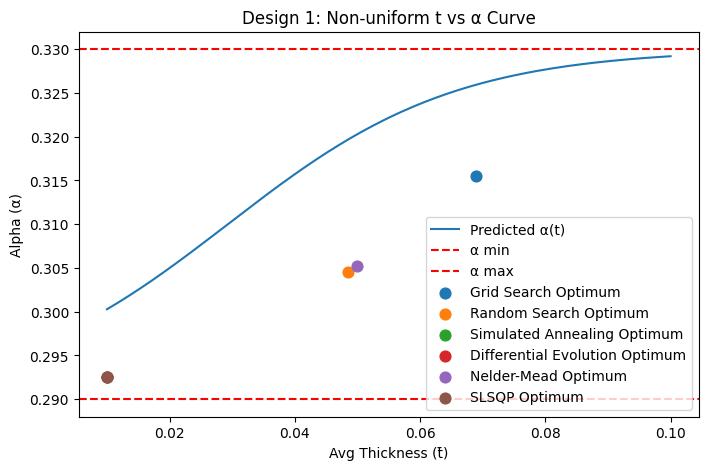

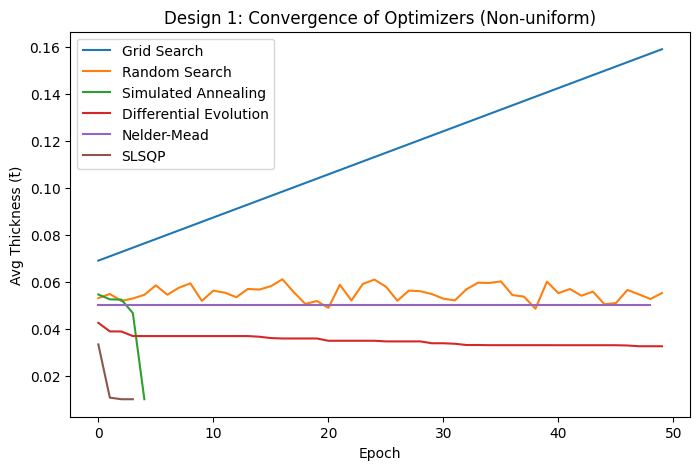


Design 2: n=40, Diameter=9.35, Density=25
Grid Search               | t̄ = 0.069000 | α = 0.318213
Random Search             | t̄ = 0.049836 | α = 0.308193
Simulated Annealing       | t̄ = 0.010000 | α = 0.293413
Differential Evolution    | t̄ = 0.010000 | α = 0.293413
Nelder-Mead               | t̄ = 0.050000 | α = 0.308284
SLSQP                     | t̄ = 0.010000 | α = 0.293413


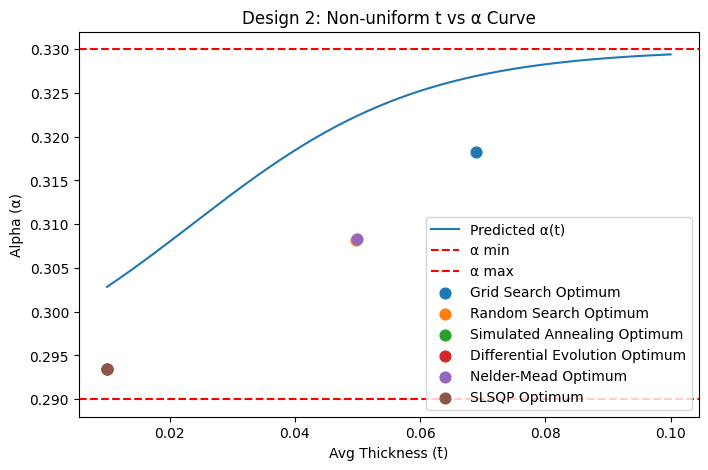

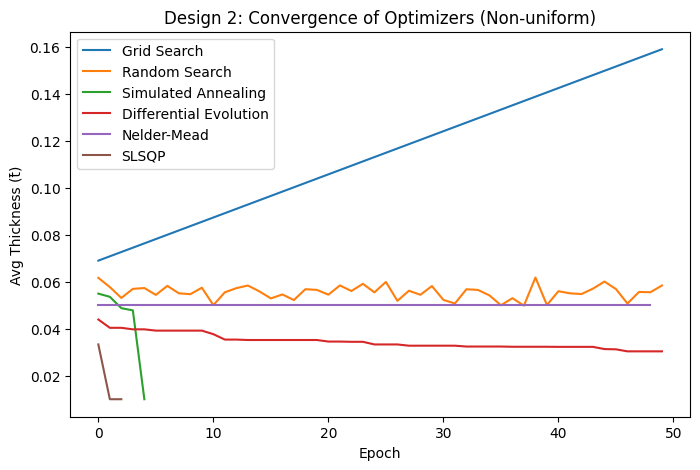


Design 3: n=32, Diameter=5.8, Density=18
Grid Search               | t̄ = 0.069000 | α = 0.315797
Random Search             | t̄ = 0.045031 | α = 0.303083
Simulated Annealing       | t̄ = 0.010000 | α = 0.292644
Differential Evolution    | t̄ = 0.010000 | α = 0.292644
Nelder-Mead               | t̄ = 0.050000 | α = 0.305593
SLSQP                     | t̄ = 0.010000 | α = 0.292644


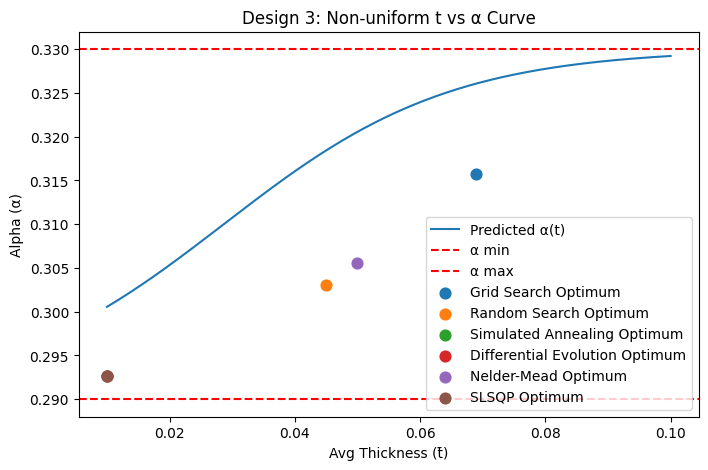

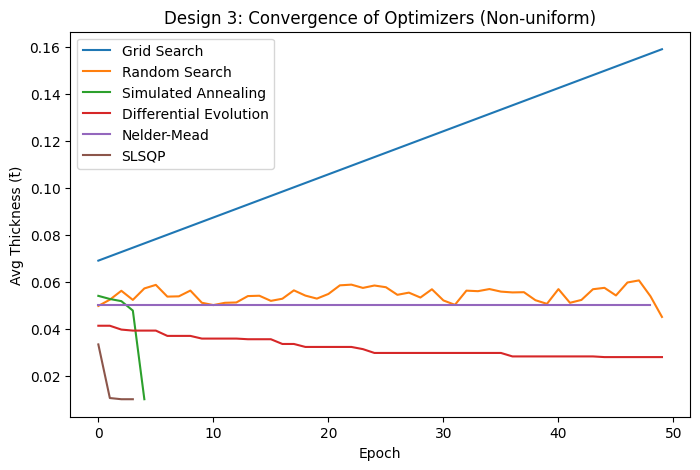

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import dual_annealing, differential_evolution, minimize

DATA_PATH = "Horizontal_Dataset_nonuniform.csv"
TH_MIN_GLOBAL = 0.01
TH_MAX_GLOBAL = 0.1
ALPHA_MIN = 0.29
ALPHA_MAX = 0.33
PENALTY = 1e6
EPOCHS = 50

a0, a1, a2, a3, a4, a5, a6 = -3.5, 5.5, 0.8, 0.4, 0.6, 0.3, 0.2
D_REF, RHO_REF, N_REF, BCON_REF, CON_REF = 10.0, 25.0, 40.0, 100.0, 50.0

data = pd.read_csv(DATA_PATH)
thickness_cols = [c for c in data.columns if "Thickness_" in c]

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def predict_alpha(row, t_list):
    D, rho, n = row["Diameter (m)"], row["Density (kN/m³)"], row["n"]
    bcon = row.get("bcon", 50.0)
    con = row.get("con", 30.0)
    t_mean = np.mean(t_list)
    var_term = np.var(t_list)
    x = (a0 +
         a1 * (t_mean / TH_MAX_GLOBAL) -
         0.2 * var_term +
         a2 * (D / D_REF) +
         a3 * (rho / RHO_REF) -
         a4 * (n / N_REF) +
         a5 * (bcon / BCON_REF) -
         a6 * (con / CON_REF))
    alpha = 0.29 + 0.04 * sigmoid(x)
    return float(alpha)

# ✅ New function to handle penalties
def penalty_function(t_list, alpha):
    penalty = 0
    if np.any(t_list < TH_MIN_GLOBAL) or np.any(t_list > TH_MAX_GLOBAL):
        penalty += PENALTY
    if alpha < ALPHA_MIN or alpha > ALPHA_MAX:
        penalty += PENALTY + abs(alpha - 0.31) * 1e4
    return penalty

def objective(t_list, row):
    t_list = np.clip(np.array(t_list), TH_MIN_GLOBAL, TH_MAX_GLOBAL)
    alpha = predict_alpha(row, t_list)
    penalty = penalty_function(t_list, alpha)
    return np.mean(t_list) + penalty

def grid_search(row, steps=EPOCHS, logs=None):
    t_matrix = [np.linspace(TH_MIN_GLOBAL, TH_MAX_GLOBAL, steps) for _ in thickness_cols]
    best_val, best_t = np.inf, None
    history = []
    for t_val in np.linspace(TH_MIN_GLOBAL, TH_MAX_GLOBAL, steps):
        t_list = [t_val + (i * 0.002) for i in range(len(thickness_cols))]
        val = objective(t_list, row)
        history.append((len(history), np.mean(t_list)))
        if val < best_val:
            best_val, best_t = val, t_list
    if logs is not None:
        logs["Grid Search"] = history
    return np.array(best_t)

def random_search(row, trials=EPOCHS, logs=None):
    best_t, best_val = None, np.inf
    history = []
    for i in range(trials):
        t_list = np.random.uniform(TH_MIN_GLOBAL, TH_MAX_GLOBAL, len(thickness_cols))
        val = objective(t_list, row)
        history.append((i, np.mean(t_list)))
        if val < best_val:
            best_t, best_val = t_list, val
    if logs is not None:
        logs["Random Search"] = history
    return np.array(best_t)

def simulated_annealing(row, logs=None):
    bounds = [(TH_MIN_GLOBAL, TH_MAX_GLOBAL)] * len(thickness_cols)
    history = []
    def callback(x, f, context):
        history.append((len(history), np.mean(x)))
    res = dual_annealing(lambda x: objective(x, row),
                         bounds=bounds, maxiter=EPOCHS, callback=callback)
    if logs is not None:
        logs["Simulated Annealing"] = history
    return np.array(res.x)

def diff_evo(row, logs=None):
    bounds = [(TH_MIN_GLOBAL, TH_MAX_GLOBAL)] * len(thickness_cols)
    history = []
    def callback(xk, convergence):
        history.append((len(history), np.mean(xk)))
    res = differential_evolution(lambda x: objective(x, row),
                                 bounds=bounds, maxiter=EPOCHS,
                                 popsize=8, mutation=(0.5, 1.0),
                                 recombination=0.7, callback=callback)
    if logs is not None:
        logs["Differential Evolution"] = history
    return np.array(res.x)

def nelder_mead(row, logs=None):
    x0 = np.array([0.05] * len(thickness_cols))
    history = []
    def callback(xk):
        history.append((len(history), np.mean(xk)))
    res = minimize(lambda x: objective(x, row),
                   x0, method="Nelder-Mead",
                   callback=callback, options={"maxiter": EPOCHS})
    if logs is not None:
        logs["Nelder-Mead"] = history
    return np.array(res.x)

def slsqp_refine(row, logs=None):
    def cons_low(x): return predict_alpha(row, x) - ALPHA_MIN
    def cons_high(x): return ALPHA_MAX - predict_alpha(row, x)
    history = []
    def callback(xk): history.append((len(history), np.mean(xk)))
    res = minimize(lambda x: np.mean(x), np.array([0.05]*len(thickness_cols)), method="SLSQP",
                   bounds=[(TH_MIN_GLOBAL, TH_MAX_GLOBAL)]*len(thickness_cols),
                   constraints=[{"type": "ineq", "fun": cons_low},
                                {"type": "ineq", "fun": cons_high}],
                   callback=callback, options={"maxiter": EPOCHS})
    if logs is not None:
        logs["SLSQP"] = history
    return np.array(res.x)

METHODS = [
    ("Grid Search", grid_search),
    ("Random Search", random_search),
    ("Simulated Annealing", simulated_annealing),
    ("Differential Evolution", diff_evo),
    ("Nelder-Mead", nelder_mead),
    ("SLSQP", slsqp_refine)
]

if __name__ == "__main__":
    sample_rows = data.sample(3, random_state=42).reset_index(drop=True)
    for idx, row in sample_rows.iterrows():
        print("\n" + "=" * 60)
        print(f"Design {idx+1}: n={int(row['n'])}, Diameter={row['Diameter (m)']}, Density={row['Density (kN/m³)']}")
        logs = {}
        results = []
        for name, method in METHODS:
            try:
                t_opt_list = method(row, logs=logs)
                alpha_opt = predict_alpha(row, t_opt_list)
                valid = ALPHA_MIN <= alpha_opt <= ALPHA_MAX
            except Exception:
                t_opt_list, alpha_opt, valid = None, None, False
            if valid:
                print(f"{name:<25} | t̄ = {np.mean(t_opt_list):.6f} | α = {alpha_opt:.6f}")
                results.append((name, np.mean(t_opt_list), alpha_opt))
            else:
                print(f"{name:<25} | No feasible result")

        t_range = np.linspace(TH_MIN_GLOBAL, TH_MAX_GLOBAL, 200)
        alphas = [predict_alpha(row, [t + i*0.001 for i in range(len(thickness_cols))]) for t in t_range]
        plt.figure(figsize=(8, 5))
        plt.plot(t_range, alphas, label="Predicted α(t)")
        plt.axhline(ALPHA_MIN, color="r", linestyle="--", label="α min")
        plt.axhline(ALPHA_MAX, color="r", linestyle="--", label="α max")
        for name, t_opt, a_opt in results:
            plt.scatter(t_opt, a_opt, label=f"{name} Optimum", s=60)
        plt.xlabel("Avg Thickness (t̄)")
        plt.ylabel("Alpha (α)")
        plt.title(f"Design {idx+1}: Non-uniform t vs α Curve")
        plt.legend()
        plt.show()

        plt.figure(figsize=(8, 5))
        for name, hist in logs.items():
            if hist:
                iters, tvals = zip(*hist)
                plt.plot(iters, tvals, label=name)
        plt.xlabel("Epoch")
        plt.ylabel("Avg Thickness (t̄)")
        plt.title(f"Design {idx+1}: Convergence of Optimizers (Non-uniform)")
        plt.legend()
        plt.show()


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import dual_annealing, differential_evolution, minimize

DATA_PATH = "Horizontal_Dataset_nonuniform.csv"
TH_MIN_GLOBAL = 0.01
TH_MAX_GLOBAL = 0.1
ALPHA_MIN = 0.29
ALPHA_MAX = 0.33
PENALTY = 1e6
EPOCHS = 50

a0, a1, a2, a3, a4, a5, a6 = -3.5, 5.5, 0.8, 0.4, 0.6, 0.3, 0.2
D_REF, RHO_REF, N_REF, BCON_REF, CON_REF = 10.0, 25.0, 40.0, 100.0, 50.0

data = pd.read_csv(DATA_PATH)
thickness_cols = [c for c in data.columns if "Thickness_" in c]

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def predict_alpha(row, t_list):
    D, rho, n = row["Diameter (m)"], row["Density (kN/m³)"], row["n"]
    bcon = row.get("bcon", 50.0)
    con = row.get("con", 30.0)
    t_mean = np.mean(t_list)
    var_term = np.var(t_list)
    x = (a0 +
         a1 * (t_mean / TH_MAX_GLOBAL) -
         0.2 * var_term +
         a2 * (D / D_REF) +
         a3 * (rho / RHO_REF) -
         a4 * (n / N_REF) +
         a5 * (bcon / BCON_REF) -
         a6 * (con / CON_REF))
    alpha = 0.29 + 0.04 * sigmoid(x)
    return float(alpha)

def objective(t_list, row):
    t_list = np.clip(np.array(t_list), TH_MIN_GLOBAL, TH_MAX_GLOBAL)
    alpha = predict_alpha(row, t_list)
    penalty = 0
    if np.any(t_list < TH_MIN_GLOBAL) or np.any(t_list > TH_MAX_GLOBAL):
        penalty += PENALTY
    if alpha < ALPHA_MIN or alpha > ALPHA_MAX:
        penalty += PENALTY + abs(alpha - 0.31) * 1e4
    return np.mean(t_list) + penalty

def grid_search(row, steps=EPOCHS, logs=None):
    best_val, best_t = np.inf, None
    history = []
    for t_val in np.linspace(TH_MIN_GLOBAL, TH_MAX_GLOBAL, steps):
        t_list = [t_val + (i * 0.002) for i in range(len(thickness_cols))]
        val = objective(t_list, row)
        history.append((len(history), np.mean(t_list)))
        if val < best_val:
            best_val, best_t = val, t_list
    if logs is not None:
        logs["Grid Search"] = history
    return np.array(best_t)

def random_search(row, trials=EPOCHS, logs=None):
    best_t, best_val = None, np.inf
    history = []
    for i in range(trials):
        t_list = np.random.uniform(TH_MIN_GLOBAL, TH_MAX_GLOBAL, len(thickness_cols))
        val = objective(t_list, row)
        history.append((i, np.mean(t_list)))
        if val < best_val:
            best_t, best_val = t_list, val
    if logs is not None:
        logs["Random Search"] = history
    return np.array(best_t)

def simulated_annealing(row, logs=None):
    bounds = [(TH_MIN_GLOBAL, TH_MAX_GLOBAL)] * len(thickness_cols)
    history = []
    def callback(x, f, context):
        history.append((len(history), np.mean(x)))
    res = dual_annealing(lambda x: objective(x, row),
                         bounds=bounds, maxiter=EPOCHS, callback=callback)
    if logs is not None:
        logs["Simulated Annealing"] = history
    return np.array(res.x)

def diff_evo(row, logs=None):
    bounds = [(TH_MIN_GLOBAL, TH_MAX_GLOBAL)] * len(thickness_cols)
    history = []
    def callback(xk, convergence):
        history.append((len(history), np.mean(xk)))
    res = differential_evolution(lambda x: objective(x, row),
                                 bounds=bounds, maxiter=EPOCHS,
                                 popsize=8, mutation=(0.5, 1.0),
                                 recombination=0.7, callback=callback)
    if logs is not None:
        logs["Differential Evolution"] = history
    return np.array(res.x)

def nelder_mead(row, logs=None):
    x0 = np.array([0.05] * len(thickness_cols))
    history = []
    def callback(xk):
        history.append((len(history), np.mean(xk)))
    res = minimize(lambda x: objective(x, row),
                   x0, method="Nelder-Mead",
                   callback=callback, options={"maxiter": EPOCHS})
    if logs is not None:
        logs["Nelder-Mead"] = history
    return np.array(res.x)

def slsqp_refine(row, logs=None):
    def cons_low(x): return predict_alpha(row, x) - ALPHA_MIN
    def cons_high(x): return ALPHA_MAX - predict_alpha(row, x)
    history = []
    def callback(xk): history.append((len(history), np.mean(xk)))
    res = minimize(lambda x: np.mean(x), np.array([0.05]*len(thickness_cols)), method="SLSQP",
                   bounds=[(TH_MIN_GLOBAL, TH_MAX_GLOBAL)]*len(thickness_cols),
                   constraints=[{"type": "ineq", "fun": cons_low},
                                {"type": "ineq", "fun": cons_high}],
                   callback=callback, options={"maxiter": EPOCHS})
    if logs is not None:
        logs["SLSQP"] = history
    return np.array(res.x)

METHODS = [
    ("Grid Search", grid_search),
    ("Random Search", random_search),
    ("Simulated Annealing", simulated_annealing),
    ("Differential Evolution", diff_evo),
    ("Nelder-Mead", nelder_mead),
    ("SLSQP", slsqp_refine)
]

if __name__ == "__main__":
    sample_rows = data.sample(3, random_state=42).reset_index(drop=True)
    for idx, row in sample_rows.iterrows():
        print("\n" + "=" * 60)
        print(f"Design {idx+1}: n={int(row['n'])}, Diameter={row['Diameter (m)']}, Density={row['Density (kN/m³)']}")
        logs = {}
        results = []
        for name, method in METHODS:
            try:
                t_opt_list = method(row, logs=logs)
                alpha_opt = predict_alpha(row, t_opt_list)
                valid = ALPHA_MIN <= alpha_opt <= ALPHA_MAX
            except Exception:
                t_opt_list, alpha_opt, valid = None, None, False
            if valid:
                print(f"{name:<25} | t̄ = {np.mean(t_opt_list):.6f} | α = {alpha_opt:.6f}")
                results.append((name, np.mean(t_opt_list), alpha_opt))
            else:
                print(f"{name:<25} | No feasible result")

        t_range = np.linspace(TH_MIN_GLOBAL, TH_MAX_GLOBAL, 200)
        alphas = [predict_alpha(row, [t + i*0.001 for i in range(len(thickness_cols))]) for t in t_range]
        plt.figure(figsize=(8, 5))
        plt.plot(t_range, alphas, label="Predicted α(t)")
        plt.axhline(ALPHA_MIN, color="r", linestyle="--", label="α min")
        plt.axhline(ALPHA_MAX, color="r", linestyle="--", label="α max")
        for name, t_opt, a_opt in results:
            plt.scatter(t_opt, a_opt, label=f"{name} Optimum", s=60)
        plt.xlabel("Avg Thickness (t̄)")
        plt.ylabel("Alpha (α)")
        plt.title(f"Design {idx+1}: Non-uniform t vs α Curve")
        plt.legend()
        plt.show()

        plt.figure(figsize=(8, 5))
        for name, hist in logs.items():
            if hist:
                iters, tvals = zip(*hist)
                plt.plot(iters, tvals, label=name)
        plt.xlabel("Epoch")
        plt.ylabel("Avg Thickness (t̄)")
        plt.title(f"Design {idx+1}: Convergence of Optimizers (Non-uniform)")
        plt.legend()
        plt.show()
